In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('wowah_data.csv')

In [3]:
df.head()

,char,level,race,charclass,zone,guild,timestamp
0,59425,1,Orc,Rogue,Orgrimmar,165,01/01/08 00:02:04
1,65494,9,Orc,Hunter,Durotar,-1,01/01/08 00:02:04
2,65325,14,Orc,Warrior,Ghostlands,-1,01/01/08 00:02:04
3,65490,18,Orc,Hunter,Ghostlands,-1,01/01/08 00:02:04
4,2288,60,Orc,Hunter,Hellfire Peninsula,-1,01/01/08 00:02:09


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10826734 entries, 0 to 10826733
Data columns (total 7 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   char        int64 
 1    level      int64 
 2    race       object
 3    charclass  object
 4    zone       object
 5    guild      int64 
 6    timestamp  object
dtypes: int64(3), object(4)
memory usage: 578.2+ MB


In [5]:
## 전처리

In [6]:
# 컬럼명에 있는 공백 제거
for col in df.columns:
    df = df.rename(columns={col:col.strip()})

In [7]:
# timestamp 컬럼 datetime 유형으로 변경
df['time'] = pd.to_datetime(df['timestamp'])

In [8]:
df = df.rename(columns={'time':'datetime'})

In [9]:
df['year'] = df['datetime'].dt.year  
df['month'] = df['datetime'].dt.month  

In [10]:
df['date'] = df['datetime'].dt.date  
df['time'] = df['datetime'].dt.time  

In [11]:
df = df.sort_values(by=['char', 'datetime']).reset_index(drop=True)
df['datetime_lag'] = df.groupby(by=['char'])['datetime'].shift(1) # 유저별로 이전 쿼리 시간 가져오기
df['time_diff_lag'] = df['datetime'] - df['datetime_lag'] # 이전 쿼리와의 시간 차 계산
first_play_time_idx = df[df.time_diff_lag.isna()].index  # 유저별 최초 접속 시간 행의 인덱스
first_session_time_idx = df[df['time_diff_lag'] > timedelta(minutes = 30)].index  # 유저별 세션 시작 시간 행의 인덱스

In [12]:
df['session_status'] = 9999

df.loc[first_session_time_idx, 'session_status'] = 1  # 세션이 시작된 시간
df.loc[(first_session_time_idx - 1), 'session_status'] = 2  # 세션이 끝난 시간
df.loc[first_play_time_idx, 'session_status'] = 1  # 유저별 최초 접속 시간

In [13]:
df = df.sort_values(by=['char', 'datetime'], ascending=False).reset_index(drop=True)
df['datetime_lead'] = df.groupby(by=['char'])['datetime'].shift(1) # 유저별로 다음 쿼리 시간 가져오기
df['time_diff_lead'] = df['datetime'] - df['datetime_lead'] # 다음 쿼리와의 시간 차 계산
last_play_time_idx = df[df.time_diff_lead.isna()].index  # 유저별 최종 접속 시간 행의 인덱스

df.loc[last_play_time_idx, 'session_status'] = 2  # 유저별 최종 접속 시간

In [14]:
df_session = df[(df.session_status==1) | (df.session_status==2)]  # 시간 및 끝난 시간만 저장

In [16]:
df_session = df_session.sort_values(by=['char', 'datetime']).reset_index(drop=True)

In [17]:
del df_session['time_diff_lead']

In [18]:
df_session.head()

,index,char,level,race,charclass,zone,guild,timestamp,datetime,year,month,date,time,datetime_lag,time_diff_lag,session_status,datetime_lead
0,10826733,2,18,Orc,Shaman,The Barrens,6,12/03/08 10:41:47,2008-12-03 10:41:47,2008,12,2008-12-03,10:41:47,NaT,NaT,2,NaT
1,10826732,7,54,Orc,Hunter,Feralas,-1,01/15/08 21:47:09,2008-01-15 21:47:09,2008,1,2008-01-15,21:47:09,NaT,NaT,1,2008-01-15 21:56:54
2,10826716,7,55,Orc,Hunter,Orgrimmar,282,01/16/08 00:26:56,2008-01-16 00:26:56,2008,1,2008-01-16,00:26:56,2008-01-16 00:17:12,0 days 00:09:44,2,2008-01-16 21:57:02
3,10826715,7,55,Orc,Hunter,Orgrimmar,282,01/16/08 21:57:02,2008-01-16 21:57:02,2008,1,2008-01-16,21:57:02,2008-01-16 00:26:56,0 days 21:30:06,1,2008-01-16 22:07:09
4,10826695,7,55,Orc,Hunter,Orgrimmar,282,01/17/08 01:16:49,2008-01-17 01:16:49,2008,1,2008-01-17,01:16:49,2008-01-17 01:07:06,0 days 00:09:43,2,2008-01-17 18:47:07


In [19]:
df_session['datetime_lag'] = df_session.groupby(by=['char'])['datetime'].shift(1) # 세션이 시작된 시간(이전 행 값)을 세션이 끝난 시간과 동일한 행에 배치

In [20]:
df_session['time_diff'] = df_session['datetime'] - df_session['datetime_lag']  # 세션별 게임 플레이 시간 계산

In [21]:
session_start = df_session[df_session.session_status==1][['index', 'char', 'level', 'race', 'charclass', 'zone', 'guild', 'timestamp', 'datetime']]
session_end = df_session[df_session.session_status==2][['index', 'char', 'level', 'race', 'charclass', 'zone', 'guild', 'timestamp', 'datetime', 'time_diff']]

session_start = session_start.rename(columns={'datetime':'session_start'})
session_end = session_end.rename(columns={'datetime':'session_end', 'time_diff':'playtime'})

In [22]:
session_end['date'] = session_end['session_end'].dt.date  
session_end.reset_index(drop=True, inplace=True)
session_end['playtime_hours'] = [time.total_seconds()/3600 for time in session_end.playtime]

In [62]:
session_end.head()

,level_0,index,char,level,race,charclass,zone,guild,timestamp,session_end,playtime,date,playtime_hours
0,0,10826733,2,18,Orc,Shaman,The Barrens,6,12/03/08 10:41:47,2008-12-03 10:41:47,NaT,2008-12-03,NaN
1,2,10826716,7,55,Orc,Hunter,Orgrimmar,282,01/16/08 00:26:56,2008-01-16 00:26:56,0 days 02:39:47,2008-01-16,2.663056
2,4,10826695,7,55,Orc,Hunter,Orgrimmar,282,01/17/08 01:16:49,2008-01-17 01:16:49,0 days 03:19:47,2008-01-17,3.329722
3,6,10826662,7,56,Orc,Hunter,Undercity,282,01/18/08 00:07:32,2008-01-18 00:07:32,0 days 05:20:25,2008-01-18,5.340278
4,8,10826646,7,56,Orc,Hunter,Undercity,282,01/19/08 01:47:16,2008-01-19 01:47:16,0 days 02:30:03,2008-01-19,2.500833


In [93]:
mt_24 = session_end[session_end.playtime_hours>24].index
session_end_mt24 = session_end.loc[mt_24]

In [94]:
session_end_mt24.playtime = session_end_mt24.playtime.dt.round('12h')  # 12시간 단위로 일(day) 반올림
session_end_mt24['playtime_days'] = [time.days for time in session_end_mt24.playtime]
session_end_mt24['playtime_per_day'] = session_end_mt24['playtime_hours'] / session_end_mt24['playtime_days'] 

In [96]:
del session_end_mt24['playtime_days']
del session_end_mt24['playtime_hours']
session_end_mt24 = session_end_mt24.rename(columns={'playtime_per_day':'playtime_hours'})

In [97]:
lt_24 = session_end[session_end.playtime_hours<24].index
session_end_lt_24 = session_end.loc[lt_24]

In [98]:
session_end_re = pd.concat([session_end_lt_24, session_end_mt24])

In [102]:
playtime_daily_per_user = session_end_re.groupby(by=['date', 'char']).playtime_hours.sum().reset_index()  # 날짜 및 유저별 플레이 시간

In [104]:
daily_average_playtime = playtime_daily_per_user.groupby('date').playtime_hours.mean().reset_index() # 날짜별 유저당 평균 플레이 시간

In [105]:
daily_average_playtime.playtime_hours.describe()

count    352.000000
mean       8.119055
std        0.823007
min        4.091214
25%        7.731636
50%        8.150971
75%        8.589386
max       10.617245
Name: playtime_hours, dtype: float64

<AxesSubplot:xlabel='date', ylabel='playtime_hours'>

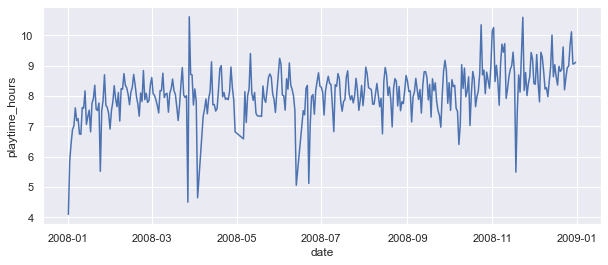

In [106]:
#daily average play time per users
plt.figure(figsize = (10,4))
sns.set(style='darkgrid')
sns.lineplot(x='date', y='playtime_hours', data=daily_average_playtime) 

In [107]:
daily_median_playtime = playtime_daily_per_user.groupby('date').playtime_hours.median().reset_index() # 날짜별 유저당 평균 플레이 시간

In [109]:
daily_median_playtime.playtime_hours.describe()

count    352.000000
mean       3.729820
std        0.783731
min        1.668056
25%        3.189375
50%        3.648264
75%        4.180903
max        6.670000
Name: playtime_hours, dtype: float64

<AxesSubplot:xlabel='date', ylabel='playtime_hours'>

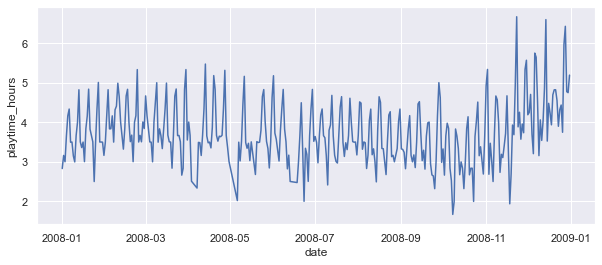

In [110]:
#daily median play time per users
plt.figure(figsize = (10,4))
sns.set(style='darkgrid')
sns.lineplot(x='date', y='playtime_hours', data=daily_median_playtime) 

In [111]:
#dau
dau = pd.DataFrame(df.groupby('date').char.nunique()).reset_index()

In [113]:
#mau
mau = pd.DataFrame(df.groupby(by=['year','month']).char.nunique()).reset_index()

<AxesSubplot:xlabel='date', ylabel='char'>

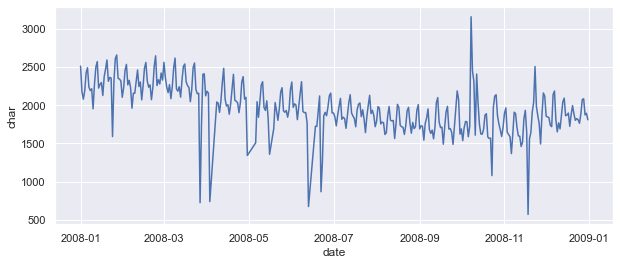

In [115]:
plt.figure(figsize = (10,4))
sns.set(style='darkgrid')
sns.lineplot(x='date', y='char', data=dau) #line plot과 구간 평균/분포로 계산됨

In [118]:
for i in range(len(mau)):
    mau.loc[i, 'time'] = str(mau.loc[i, 'year']) + '-' + str(mau.loc[i, 'month'])

<AxesSubplot:xlabel='time', ylabel='char'>

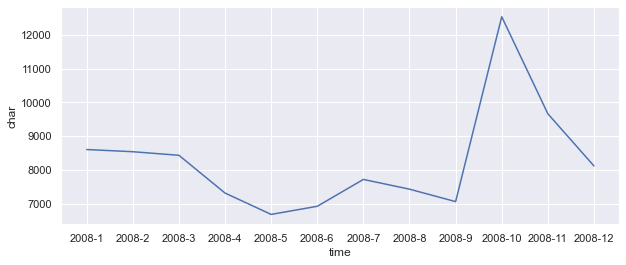

In [119]:
plt.figure(figsize = (10,4))
sns.lineplot(x='time', y='char', data=mau, sort=0)

In [236]:
# retention rate

In [120]:
df['date'][0].strftime('%Y-%m')

'2008-12'

In [121]:
#유저별로 첫번째 접속한 날짜
first_login = df.groupby(by=['char'])['date'].min().reset_index()

In [122]:
first_login = first_login.rename(columns={'date':'first_date'})

In [123]:
df_merged = pd.merge(df, first_login, how='left', on='char')

In [124]:
df_merged['day_played'] = df_merged['date'] - df_merged['first_date']

In [125]:
cohort_played = pd.pivot_table(df_merged, index=['first_date'], columns =['day_played'], values='char', aggfunc=pd.Series.nunique)

In [126]:
retention = []
for col in cohort_played.columns:
    retention_i = cohort_played[col].fillna(0).sum() / (cohort_played[col].fillna(0).astype('bool').astype('int') * cohort_played['0 days']).sum()
    retention.append(retention_i)

<AxesSubplot:xlabel='day_played'>

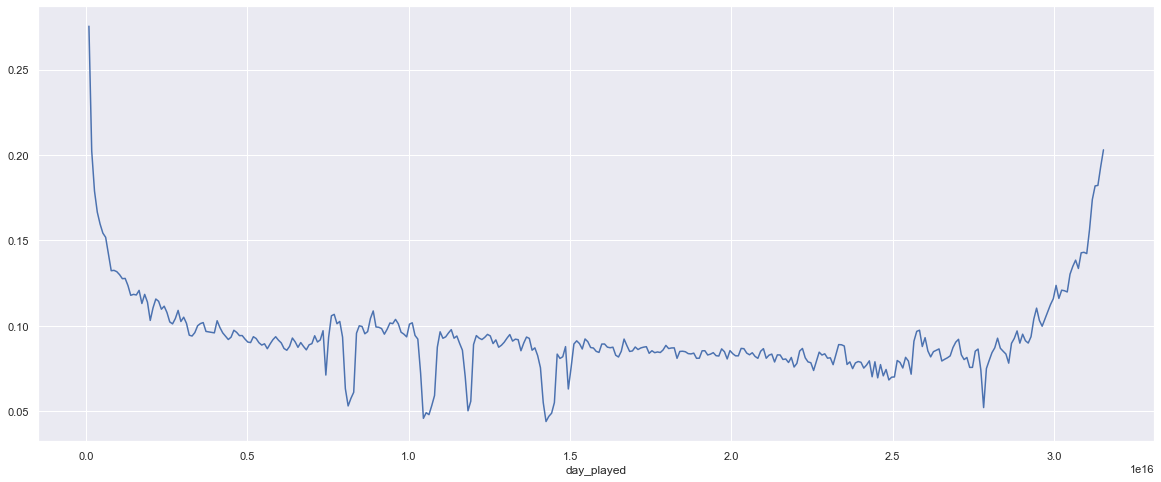

In [127]:
plt.figure(figsize = (20,8))
sns.lineplot(x=cohort_played.columns[1:], y=retention[1:])

In [152]:
#guild

In [130]:
#총 길드 개수
df.guild.nunique()

420

In [133]:
del df['level_0']
del df['index']

In [134]:
noguild_user = df[df.guild==-1].reset_index()
noguild_daily = noguild_user.groupby('date').char.nunique().reset_index()

In [135]:
noguild_daily = pd.merge(dau, noguild_daily, how='left', on='date')

In [136]:
noguild_daily = noguild_daily.rename(columns={'char_x':'dau', 'char_y':'noguild'})

In [137]:
noguild_daily['noguild_perc'] = noguild_daily['noguild'] / noguild_daily['dau']

<AxesSubplot:xlabel='date', ylabel='noguild_perc'>

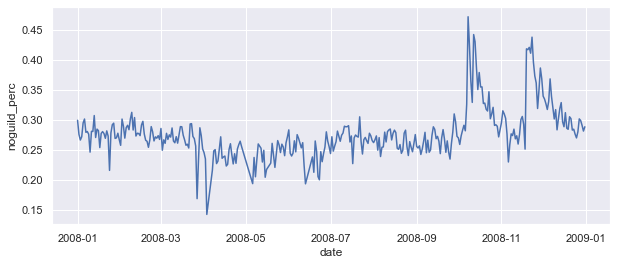

In [138]:
#dau 중 길드가 없는 유저의 비율
plt.figure(figsize = (10,4))
sns.lineplot(x='date', y='noguild_perc', data=noguild_daily, sort=0)

In [139]:
guild_size = df.groupby(by=['guild']).char.nunique().reset_index()

In [140]:
guild_size_re = guild_size[guild_size.guild!=-1]

<AxesSubplot:xlabel='char'>

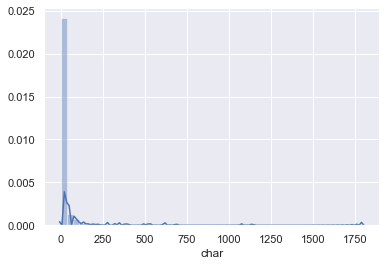

In [141]:
#대부분 소규모 길드이며 가장 규모가 큰 길드가 1750여명 정도임.
sns.distplot(guild_size_re['char'])

In [151]:
#규모가 가장 큰 길드 10곳
top_guilds = guild_size_re.sort_values(by='char', ascending=False)[:10]

In [152]:
list(top_guilds.guild)

[460, 282, 103, 251, 101, 161, 189, 104, 35, 204]

In [153]:
top_guild_users = df[df.guild.isin(list(top_guilds.guild))].reset_index()

In [154]:
top_guild_size = top_guild_users.groupby(by=['guild', 'date']).char.nunique().reset_index()

In [155]:
top_guild_size.guild = top_guild_size.guild.astype('str')

In [156]:
top_guild_size.guild = 'g_' + top_guild_size.guild 

<AxesSubplot:xlabel='date', ylabel='char'>

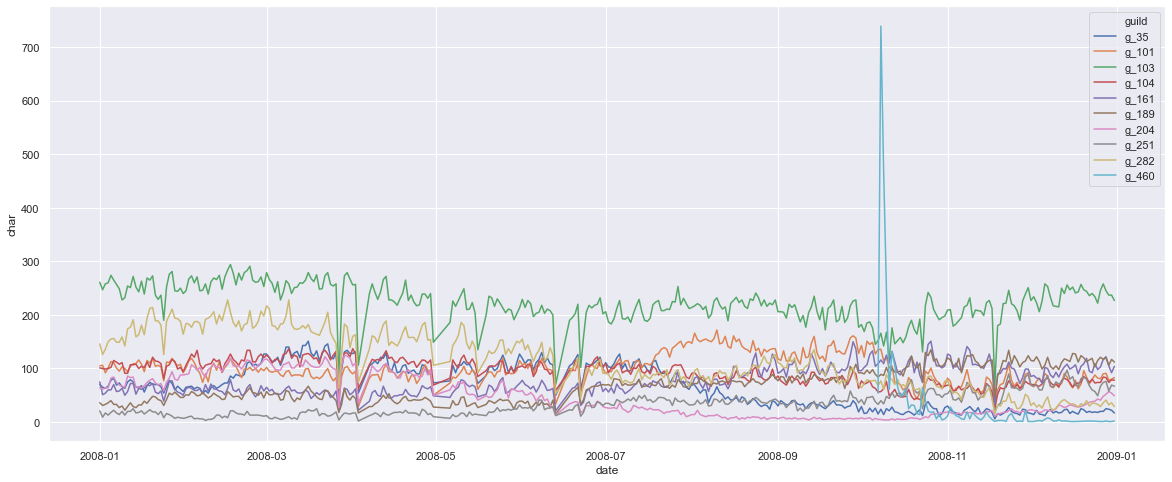

In [157]:
plt.figure(figsize = (20,8))
sns.lineplot(x='date', y='char', data=top_guild_size, hue='guild')

* 460번 길드는 2008년 10월경 신설된 후 접속자 수가 폭발적으로 늘었으나 이후 급감 : 아마 신규 확장팩 런칭 영향으로 보임

In [321]:
# 길드 규모와 플레이 시간의 관계

In [158]:
guild_size = guild_size.rename(columns={'char':'n_users'})

In [160]:
guild_playtime = session_end_re.groupby('guild').agg({'playtime_hours':'sum', 'char':'nunique'}).reset_index()

In [161]:
guild_playtime['average_playtime'] = guild_playtime['playtime_hours'] / guild_playtime['char']

In [162]:
guild_playtime_re = guild_playtime[['guild', 'average_playtime']]

In [163]:
guild_size_playtime = pd.merge(guild_playtime_re, guild_size, how='left', on='guild')

In [164]:
guild_size_playtime['n_users'].fillna(0, inplace=True)

In [165]:
guild_size_playtime_re = guild_size_playtime[guild_size_playtime.guild != -1] #길드가 없는 경우 제외
guild_size_playtime_re = guild_size_playtime_re[guild_size_playtime_re.n_users != 1] #길드원이 1명인 경우는 제외

<AxesSubplot:xlabel='n_users', ylabel='average_playtime'>

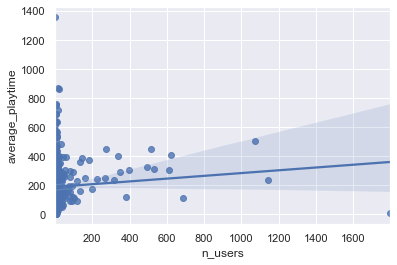

In [166]:
# 길드 사이즈와 플레이 시간의 상관관계
sns.regplot(x='n_users', y='average_playtime', data=guild_size_playtime_re)

In [167]:
#이상치 제거하기
iqr = guild_size_playtime_re['n_users'].quantile(0.75) - guild_size_playtime_re['n_users'].quantile(0.25)
outlier = (guild_size_playtime_re['n_users'] < guild_size_playtime_re['n_users'].quantile(0.25) - iqr * 1.5) | (guild_size_playtime_re['n_users'] > guild_size_playtime_re['n_users'].quantile(0.75) + iqr * 1.5)

In [168]:
guild_size_playtime_re['outlier'] = outlier

In [169]:
guild_size_playtime_re2 = guild_size_playtime_re[guild_size_playtime_re.outlier==False]

<AxesSubplot:xlabel='n_users', ylabel='average_playtime'>

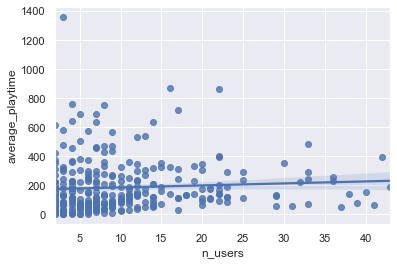

In [170]:
sns.regplot(x='n_users', y='average_playtime', data=guild_size_playtime_re2)

* 길드 규모가 늘어나면 플레이 시간이 증가 >> 길드에 가입안 한 유저들 가입하도록 독려할 필요가 있음.
* 길드를 서로 홍보할 수 있는 장을 마련
* 길드 규모를 늘리면 혜택을 추가 제공

In [ ]:
# 이탈 요인 분석

In [173]:
df = df.sort_values(by=['char', 'datetime']).reset_index()

In [174]:
first_log = df.groupby('char').first()

In [175]:
last_log = df.groupby('char').last()

In [176]:
first_log = first_log[['level', 'race', 'charclass', 'zone', 'guild', 'datetime']].reset_index()
last_log = last_log[['level', 'race', 'charclass', 'zone', 'guild', 'datetime']].reset_index()

In [177]:
first_log = first_log.rename(columns={'datetime':'first_log_time'})
last_log = last_log.rename(columns={'datetime':'last_log_time'})

In [178]:
user_time = pd.merge(first_log, last_log[['char', 'last_log_time']], on='char')

In [179]:
# 90일 이상 접속하지 않은 유저를 이탈한 유저로 규정
last_log['churn'] = pd.to_datetime('2008-12-31') - last_log.last_log_time > timedelta(days=90)

In [180]:
last_log['churn'] = last_log['churn'].astype('int')

In [181]:
churn_users = last_log[last_log.churn==1].reset_index()

In [182]:
#overall 이탈률
last_log.churn.mean() # 45%의 이탈률

0.45076832467741074

In [183]:
#유입시기별 이탈률
user_time['month'] = user_time['first_log_time'].dt.strftime('%Y-%m')

In [184]:
user_time['date'] = user_time['first_log_time'].dt.date

In [185]:
user_time['churn'] = pd.to_datetime('2008-12-31') - user_time.last_log_time > timedelta(days=90)

<AxesSubplot:xlabel='month', ylabel='churn'>

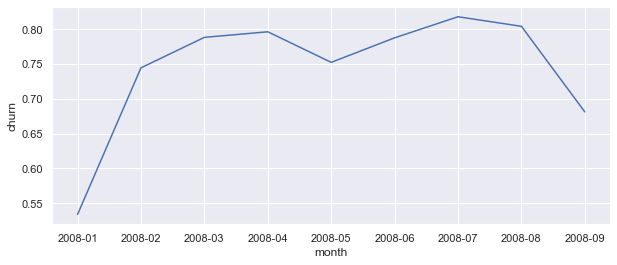

In [186]:
churn_rate_monthly = user_time.groupby('month').churn.mean().reset_index()[:9]
plt.figure(figsize = (10,4))
sns.lineplot(x='month', y='churn', data=churn_rate_monthly, sort=0)

<AxesSubplot:xlabel='date', ylabel='churn'>

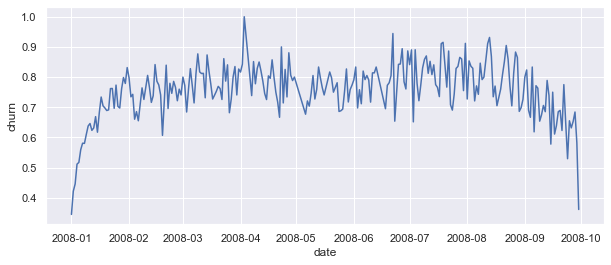

In [187]:
user_time_re = user_time[user_time.month < '2008-10']
churn_rate_daily = user_time_re.groupby('date').churn.mean().reset_index()
plt.figure(figsize = (10,4))
sns.lineplot(x='date', y='churn', data=churn_rate_daily, sort=0)

* 2008년 1월에 이탈률이 크게 증가함. 다르게 말하면 2008년 1월 초에 진입한 유저들은 게임을 계속하고 있음. 원인 파악 필요.

<AxesSubplot:xlabel='level', ylabel='char'>

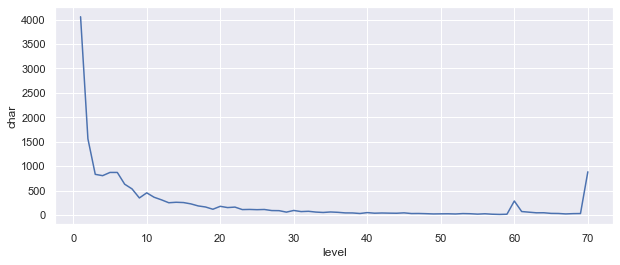

In [188]:
#레벨별 이탈율
churn_level = churn_users.groupby('level').char.count().reset_index()

plt.figure(figsize = (10,4))
sns.lineplot(x='level', y='char', data=churn_level, sort=0)

* 레벨 10 이하에서 많이 떠나므로 레벨 10까지 도달하게 만드는 것이 중요
* 레벨 60에서도 다소 떠난 유저가 많아 게임을 지속할 새로운 요인을 제공할 필요가 있음.
* 최고 레벨인 70 이후에 떠나는 유저들은 더이상 할 것이 없어서 떠나는 것으로 보임.

<AxesSubplot:xlabel='char', ylabel='zone'>

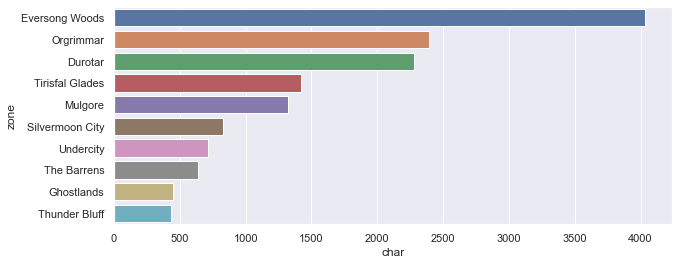

In [189]:
churn_zone = churn_users.groupby('zone').char.count().reset_index()
churn_zone_top10 = churn_zone.sort_values(by='char', ascending=False)[:10]

plt.figure(figsize = (10,4))
sns.barplot(x='char', y='zone', data=churn_zone_top10)

In [190]:
nusers_race_class = last_log.groupby(by=['race', 'charclass']).char.count().reset_index().rename(columns={'char':'total_users'})

In [191]:
cusers_race_class = churn_users.groupby(by=['race', 'charclass']).char.count().reset_index().rename(columns={'char':'churn_users'})

* 많이 이탈하는 zone에서 유저들이 어떤 장애물 때문에 떠나는 지 확인 필요

In [192]:
race_n_class = pd.merge(nusers_race_class, cusers_race_class, on=['race', 'charclass'])
race_n_class['churn_rate'] = race_n_class['churn_users'] / race_n_class['total_users']

In [193]:
race_n_class = race_n_class.sort_values(by='churn_rate', ascending=False)

In [194]:
race_n_class['race-class'] = race_n_class['race'] + '-' + race_n_class['charclass']

<AxesSubplot:xlabel='churn_rate', ylabel='race-class'>

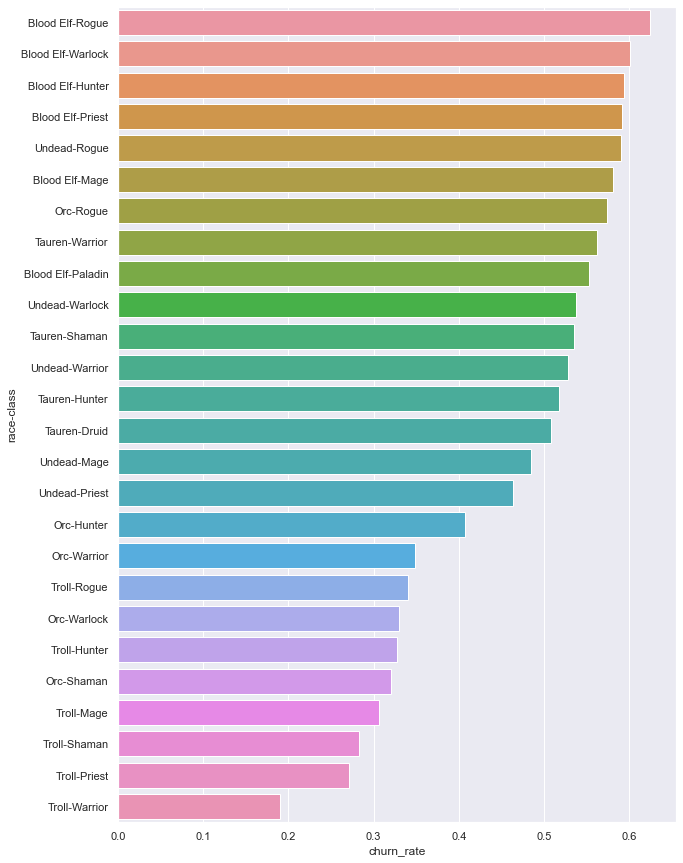

In [195]:
plt.figure(figsize = (10,15))
sns.barplot(x='churn_rate', y='race-class', data=race_n_class)

* 대체로 bloodelf의 이탈률이 높아서 원인 파악 필요
* 초심자에게는 troll-warrior 조합을 추천

In [ ]:
* 어둠땅부턴 종족이나 직업 퀘스트/추방자의 해안으로 10레벨까지 / 격전의 아제로스 지역에서 50레벨까지 / 어둠땅 지역에서 60레벨까지

In [335]:
zones = pd.read_csv('zones.csv')

In [219]:
locations = pd.read_csv('locations.csv')

In [334]:
zones

,zone,Continent,Area,Zone,Subzone,Type,Size,Controlled,Min_req_level,Min_rec_level,Max_rec_level,Min_bot_level,Max_bot_level
0,Durotar,Kalimdor,Central Kalimdor,Durotar,NaN,Zone,NaN,Horde,1,1.0,10.0,1.0,10.0
1,The Barrens,Kalimdor,Central Kalimdor,The Barrens,NaN,Zone,NaN,Contested,1,10.0,35.0,10.0,35.0
2,Silverpine Forest,Eastern Kingdoms,Lordaeron,Silverpine Forest,NaN,Zone,NaN,Horde,1,10.0,20.0,10.0,20.0
3,Stonetalon Mountains,Kalimdor,Central Kalimdor,Stonetalon Mountains,NaN,Zone,NaN,Contested,1,25.0,30.0,25.0,30.0
4,Thunder Bluff,Kalimdor,Central Kalimdor,Thunder Bluff,NaN,City,NaN,Horde,1,1.0,100.0,1.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,Vault of Archavon,Northrend,Northrend,Wintergrasp,Wintergrasp Fortress,Dungeon,25.0,Contested,80,80.0,80.0,80.0,80.0
156,The Eye of Eternity,Northrend,Northrend,Borean Tundra,Coldarra,Dungeon,25.0,Contested,80,80.0,80.0,80.0,80.0
157,The Obsidian Sanctum,Northrend,Northrend,Dragonblight,Chamber of Aspects,Dungeon,25.0,Contested,80,80.0,80.0,80.0,80.0
158,<U+9F8D><U+9AA8><U+8352><U+91CE>,Northrend,Northrend,Dragonblight,Dragonblight,Zone,NaN,Contested,1,72.0,75.0,72.0,75.0


In [224]:
# 지역별 최소 레벨
zone_level_min = zones[['Zone_Name', 'Min_req_level']].rename(columns={'Zone_Name':'zone'})

In [225]:
zone_churn_levele = pd.merge(churn_zone, zone_level_min, on='zone')

<AxesSubplot:xlabel='Min_req_level', ylabel='char'>

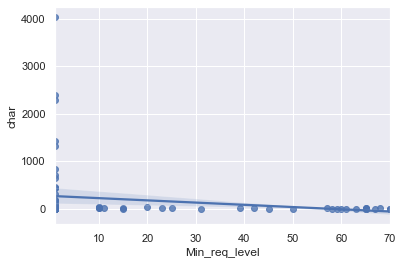

In [228]:
sns.regplot(x='Min_req_level', y='char', data=zone_churn_level)

In [229]:
zone_churn_level.sort_values(by='char', ascending=False)[:20]

,zone,char,Min_req_level
25,Eversong Woods,4037,1
46,Orgrimmar,2394,1
20,Durotar,2277,1
77,Tirisfal Glades,1423,1
42,Mulgore,1319,1
57,Silvermoon City,825,1
79,Undercity,717,1
65,The Barrens,635,1
30,Ghostlands,447,1
76,Thunder Bluff,431,1


* eversongwoods: 영원노래의 숲: 블러드 엘프 캐릭터로 플레이할 경우 여기에서 게임을 시작. 퀘스트 동선이 산들바람 마을을 중심으로 서부 성소, 원정순찰대 산장, 숲 남부 등 여기저기 돌아다니도록 짜여 있기 때문에 매우 피곤. 블러드 엘프 종족으로 시작하는 경우 이탈이 심한 이유가 이것 아닌지.
* 오그리마 : 정문에 서있던 사울팽,[2] 굴곡이 심한 지형, 구불구불한 길, 곳곳에 산재한 뒷골목 등 구조가 매우 복잡하다. 특히 수장인 스랄까지의 접근성이 최악
* 듀로타 : 눈 아프다. 필드 전체가 밝으면서 새빨갛기 때문에 불모의 땅의 황색에 눈이 익숙해져 있는 상태에서 진입하면 부담

In [231]:
zone_churn_level_high = zone_churn_level[zone_churn_level.Min_req_level>50]
zone_churn_level_high.sort_values(by='char', ascending=False)[:20]

,zone,char,Min_req_level
34,Hellfire Ramparts,8,57
37,Karazhan,8,68
39,Magisters' Terrace,6,65
70,The Mechanar,4,65
40,Mana-Tombs,3,61
63,Tempest Keep,3,70
71,The Shattered Halls,2,65
72,The Steamvault,2,65
74,The Underbog,2,60
7,Black Temple,1,70


In [233]:
zone_level_min

,zone,Min_req_level
0,Durotar,1
1,The Barrens,1
2,Silverpine Forest,1
3,Stonetalon Mountains,1
4,Thunder Bluff,1
...,...,...
155,Vault of Archavon,80
156,The Eye of Eternity,80
157,The Obsidian Sanctum,80
158,<U+9F8D><U+9AA8><U+8352><U+91CE>,1


In [235]:
df_zone = pd.merge(df, zone_level_min, how='left', on='zone')

In [238]:
df_zone_user = df_zone.groupby('char').agg({'level':'max', 'Min_req_level':'max'}) #유저별 최종 레벨과 도달한 지역 중 가장 높은 레벨을 요구한 경우

In [283]:
df_zone_user['level10'] = df_zone_user.Min_req_level.map(lambda x: '1-10' if x <= 10 else None)
df_zone_user['level20'] = df_zone_user.Min_req_level.map(lambda x: '10-20' if x <= 20 and x > 10 else None)
df_zone_user['level30'] = df_zone_user.Min_req_level.map(lambda x: '20-30' if x <= 30 and x > 20 else None)
df_zone_user['level40'] = df_zone_user.Min_req_level.map(lambda x: '30-40' if x <= 40 and x > 30 else None)
df_zone_user['level50'] = df_zone_user.Min_req_level.map(lambda x: '40-50' if x <= 50 and x > 40 else None)
df_zone_user['level60'] = df_zone_user.Min_req_level.map(lambda x: '50-60' if x <= 60 and x > 50 else None)
df_zone_user['level70'] = df_zone_user.Min_req_level.map(lambda x: '60-70' if x <= 70 and x > 60 else None)
df_zone_user['level80'] = df_zone_user.Min_req_level.map(lambda x: '70-80' if x <= 80 and x > 70 else None)

In [313]:
df_zone_user_re = df_zone_user.fillna('')

In [314]:
df_zone_user_re['level_range'] = df_zone_user_re['level10'] + df_zone_user_re['level20'] + df_zone_user_re['level30'] + df_zone_user_re['level40'] \
                                + df_zone_user_re['level50'] + df_zone_user_re['level60'] + df_zone_user_re['level70'] + df_zone_user_re['level80']

In [315]:
df_zone_user_re = df_zone_user_re[['level', 'Min_req_level', 'level_range']]

In [316]:
level_funnel_df = df_zone_user_re.groupby('level_range').count().reset_index()[['level_range', 'Min_req_level']].rename(columns={'Min_req_level':'users'})

In [317]:
level_funnel_df = level_funnel_df.sort_values(by='level_range', ascending=False)

In [318]:
level_funnel_df['cumsum_users'] = level_funnel_df.users.cumsum()

In [319]:
level_funnel_df = level_funnel_df.sort_values(by='level_range', ascending=True)

In [320]:
#전체 유저 대비 단계별 전환율 계산
level_funnel_df.cumsum_users / level_funnel_df.cumsum_users[0]

0    1.000000
1    0.185040
2    0.167104
3    0.147267
4    0.131338
5    0.122584
6    0.107137
7    0.026530
Name: cumsum_users, dtype: float64

In [321]:
#이전 단계별 전환율 계산
for i in range(len(level_funnel_df)-1):
    level_funnel_df.loc[i+1, 'conversion'] = level_funnel_df.loc[i+1, 'cumsum_users'] / level_funnel_df.loc[i, 'cumsum_users']

In [322]:
level_funnel_df

,level_range,users,cumsum_users,conversion
0,1-10,30442,37354,NaN
1,10-20,670,6912,0.185040
2,20-30,741,6242,0.903067
3,30-40,595,5501,0.881288
4,40-50,327,4906,0.891838
5,50-60,577,4579,0.933347
6,60-70,3011,4002,0.873990
7,70-80,991,991,0.247626


* 리치왕의분노(리분) 런칭 후 퍼널 전환율 분석

In [310]:
df_lk = df_zone[df_zone.datetime >= '2008-11-13'].reset_index()

In [323]:
df_zone_user_lk = df_lk.groupby('char').agg({'level':'max', 'Min_req_level':'max'}) #유저별 최종 레벨과 도달한 지역 중 가장 높은 레벨을 요구한 경우

df_zone_user_lk['level10'] = df_zone_user_lk.Min_req_level.map(lambda x: '1-10' if x <= 10 else None)
df_zone_user_lk['level20'] = df_zone_user_lk.Min_req_level.map(lambda x: '10-20' if x <= 20 and x > 10 else None)
df_zone_user_lk['level30'] = df_zone_user_lk.Min_req_level.map(lambda x: '20-30' if x <= 30 and x > 20 else None)
df_zone_user_lk['level40'] = df_zone_user_lk.Min_req_level.map(lambda x: '30-40' if x <= 40 and x > 30 else None)
df_zone_user_lk['level50'] = df_zone_user_lk.Min_req_level.map(lambda x: '40-50' if x <= 50 and x > 40 else None)
df_zone_user_lk['level60'] = df_zone_user_lk.Min_req_level.map(lambda x: '50-60' if x <= 60 and x > 50 else None)
df_zone_user_lk['level70'] = df_zone_user_lk.Min_req_level.map(lambda x: '60-70' if x <= 70 and x > 60 else None)
df_zone_user_lk['level80'] = df_zone_user_lk.Min_req_level.map(lambda x: '70-80' if x <= 80 and x > 70 else None)

df_zone_user_lk_re = df_zone_user_lk.fillna('')

df_zone_user_lk_re['level_range'] = df_zone_user_lk_re['level10'] + df_zone_user_lk_re['level20'] + df_zone_user_lk_re['level30'] + df_zone_user_lk_re['level40'] \
                                + df_zone_user_lk_re['level50'] + df_zone_user_lk_re['level60'] + df_zone_user_lk_re['level70'] + df_zone_user_lk_re['level80']

In [324]:
df_zone_user_lk_re = df_zone_user_lk_re[['level', 'Min_req_level', 'level_range']]

In [325]:
level_funnel_df = df_zone_user_lk_re.groupby('level_range').count().reset_index()[['level_range', 'Min_req_level']].rename(columns={'Min_req_level':'users'})
level_funnel_df = level_funnel_df.sort_values(by='level_range', ascending=False)
level_funnel_df['cumsum_users'] = level_funnel_df.users.cumsum()
level_funnel_df = level_funnel_df.sort_values(by='level_range', ascending=True)

In [326]:
#전체 유저 대비 단계별 전환율 계산
level_funnel_df.cumsum_users / level_funnel_df.cumsum_users[0]

0    1.000000
1    0.235726
2    0.221407
3    0.207962
4    0.191549
5    0.182906
6    0.161254
7    0.086520
Name: cumsum_users, dtype: float64

In [327]:
#이전 단계별 전환율 계산
for i in range(len(level_funnel_df)-1):
    level_funnel_df.loc[i+1, 'conversion'] = level_funnel_df.loc[i+1, 'cumsum_users'] / level_funnel_df.loc[i, 'cumsum_users']

In [328]:
level_funnel_df

,level_range,users,cumsum_users,conversion
0,1-10,8754,11454,NaN
1,10-20,164,2700,0.235726
2,20-30,154,2536,0.939259
3,30-40,188,2382,0.939274
4,40-50,99,2194,0.921075
5,50-60,248,2095,0.954877
6,60-70,856,1847,0.881623
7,70-80,991,991,0.536546


* 리분 런칭 이후 모든 단계의 전환율이 상승했으며, 새로 개설된 70-80 레벨 구간까지 진입한 유저도 이전 단계 대비 50퍼센트 이상으로 확인됨.

In [336]:
zones_type = zones[['Zone_Name', 'Type']].rename(columns={'Zone_Name':'zone'})

In [337]:
df_zone_type = pd.merge(df, zones_type, how='left', on='zone')

In [341]:
df_zone_type.groupby('Type').index.count().sort_values(ascending=False)

Type
Zone            6513372
Dungeon         2308251
City             957109
Battleground     936464
Arena            110201
Sea                 978
Event               165
Transit              51
Name: index, dtype: int64

In [347]:
guild_zone = df_zone_type.groupby(by=['guild', 'Type']).index.count().sort_values(ascending=False)

In [361]:
guild_zone = pd.pivot_table(df_zone_type, values='index', index=['guild'], columns=['Type'], aggfunc='count').fillna(0)

In [371]:
guild_zone['total'] = guild_zone.sum(axis=1)

In [376]:
for col in guild_zone.columns:
    guild_zone[col+'_p'] = guild_zone[col] / guild_zone['total']

In [378]:
guild_zone_re = guild_zone[['Arena_p', 'Battleground_p', 'City_p', 'Dungeon_p', 'Event_p', 'Sea_p', 'Transit_p', 'Zone_p']]

In [393]:
guild_zone_re = guild_zone_re.reset_index()

In [395]:
guild_zone_re = pd.merge(guild_zone_re, guild_size_playtime, on='guild')

In [403]:
#이상치 제거하기
iqr = guild_zone_re['n_users'].quantile(0.75) - guild_zone_re['n_users'].quantile(0.25)
outlier = (guild_zone_re['n_users'] < guild_zone_re['n_users'].quantile(0.25) - iqr * 1.5) | (guild_zone_re['n_users'] > guild_zone_re['n_users'].quantile(0.75) + iqr * 1.5)

In [404]:
guild_zone_re['outlier'] = outlier

In [405]:
guild_zone_re2 = guild_zone_re[guild_zone_re.outlier==False]

<AxesSubplot:xlabel='n_users', ylabel='City_p'>

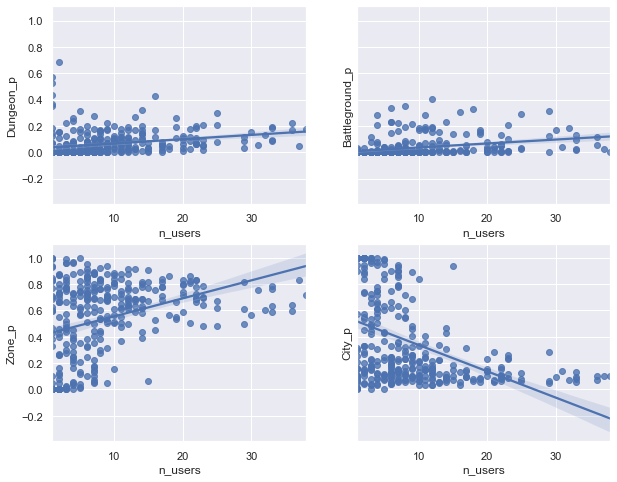

In [433]:
fig, axes = plt.subplots(ncols=2, nrows=2, sharey=True, figsize=(10, 8))
sns.regplot(x='n_users', y='Dungeon_p', data=guild_zone_re2, ax=axes[0, 0])
sns.regplot(x='n_users', y='Battleground_p', data=guild_zone_re2, ax=axes[0, 1])
sns.regplot(x='n_users', y='Zone_p', data=guild_zone_re2, ax=axes[1, 0])
sns.regplot(x='n_users', y='City_p', data=guild_zone_re2, ax=axes[1, 1])

* 길드의 사이즈가 커질수록 던전, 배틀그라운드, zone에서 활동량이 증가
* 반대로 길드 사이즈가 클수록 도시 활동은 감소
* 던전과 배틀그라운드에서 활동을 증가시키려면 길드 규모가 커지게 할 필요가 있음.